<center><img src="https://raw.githubusercontent.com/openvinotoolkit/anomalib/main/docs/source/images/logos/anomalib-wide-blue.png" alt="Paris" class="center"></center>

<center>💙 A library for benchmarking, developing and deploying deep learning anomaly detection algorithms</center>

______________________________________________________________________

> NOTE:
> This notebook is originally created by @innat on [Kaggle](https://www.kaggle.com/code/ipythonx/mvtec-ad-anomaly-detection-with-anomalib-library/notebook).

[Anomalib](https://github.com/openvinotoolkit/anomalib): Anomalib is a deep learning library that aims to collect state-of-the-art anomaly detection algorithms for benchmarking on both public and private datasets. Anomalib provides several ready-to-use implementations of anomaly detection algorithms described in the recent literature, as well as a set of tools that facilitate the development and implementation of custom models. The library has a strong focus on image-based anomaly detection, where the goal of the algorithm is to identify anomalous images, or anomalous pixel regions within images in a dataset.

The library supports [`MVTec AD`](https://www.mvtec.com/company/research/datasets/mvtec-ad) (CC BY-NC-SA 4.0) and [`BeanTech`](https://paperswithcode.com/dataset/btad) (CC-BY-SA) for **benchmarking** and `folder` for custom dataset **training/inference**. In this notebook, we will explore `anomalib` training a PADIM model on the `MVTec AD` bottle dataset and evaluating the model's performance. The sections in this notebook explores the steps in `tools/train.py` more in detail. Those who would like to reproduce the results via CLI could use `python tools/train.py --model padim`.

## Installing Anomalib

Installation can be done in two ways: (i) install via PyPI, or (ii) installing from sourc, both of which are shown below:

### I. Install via PyPI

In [1]:
# Option - I: Uncomment the next line if you want to install via pip.
%pip install anomalib

Note: you may need to restart the kernel to use updated packages.


### II. Install from Source
This option would initially download anomalib repository from github and manually install `anomalib` from source, which is shown below:

In [2]:
# Option - II: Uncomment the next three lines if you want to install from the source.
# !git clone https://github.com/openvinotoolkit/anomalib.git
# %cd anomalib
# %pip install .

 Now let's verify the working directory. This is to access the datasets and configs when the notebook is run from different platforms such as local or Google Colab.

In [1]:
from __future__ import annotations

import os
from pathlib import Path
from typing import Any

from git.repo import Repo

current_directory = Path.cwd()
if current_directory.name == "000_getting_started":
    # On the assumption that, the notebook is located in
    #   ~/anomalib/notebooks/000_getting_started/
    root_directory = current_directory.parent.parent
elif current_directory.name == "anomalib":
    # This means that the notebook is run from the main anomalib directory.
    root_directory = current_directory
else:
    # Otherwise, we'll need to clone the anomalib repo to the `current_directory`
    repo = Repo.clone_from(url="https://github.com/openvinotoolkit/anomalib.git", to_path=current_directory)
    root_directory = current_directory / "anomalib"

os.chdir(root_directory)

## Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from pytorch_lightning import Trainer
from torchvision.transforms import ToPILImage

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer
from anomalib.models import get_model
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks

from openvino.runtime import Core

/home/raspberrypi/openvino_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model

Currently, there are **13** anomaly detection models available in `anomalib` library. Namely,

- [CFA](https://arxiv.org/abs/2206.04325)
- [CS-Flow](https://arxiv.org/abs/2110.02855v1)
- [CFlow](https://arxiv.org/pdf/2107.12571v1.pdf)
- [DFKDE](https://github.com/openvinotoolkit/anomalib/tree/main/anomalib/models/dfkde)
- [DFM](https://arxiv.org/pdf/1909.11786.pdf)
- [DRAEM](https://arxiv.org/abs/2108.07610)
- [FastFlow](https://arxiv.org/abs/2111.07677)
- [Ganomaly](https://arxiv.org/abs/1805.06725)
- [Padim](https://arxiv.org/pdf/2011.08785.pdf)
- [Patchcore](https://arxiv.org/pdf/2106.08265.pdf)
- [Reverse Distillation](https://arxiv.org/abs/2201.10703)
- [R-KDE](https://ieeexplore.ieee.org/document/8999287)
- [STFPM](https://arxiv.org/pdf/2103.04257.pdf)

In this tutorial, we'll be using Padim. Now, let's get their config paths from the respected folders.

## Configuration

In this demonstration, we will choose [Padim](https://arxiv.org/pdf/2011.08785.pdf) model from the above list. Let's take a quick look at its config file.

In [14]:
MODEL = "patchcore"  # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
CONFIG_PATH = root_directory / f"src/anomalib/models/{MODEL}/config_copy.yaml"
with open(file=CONFIG_PATH, mode="r", encoding="utf-8") as file:
    print(file.read())

dataset:
  name: 50
  format: folder
  path: ./datasets/50
  normal_dir: Normal
  abnormal_dir: Abnormal
  task: classification
  split_ratio: 0.2
  mask: null
  normal_test_dir: null
  extensions: null
  normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
  center_crop: null # dimensions to which images are center-cropped after resizing (optional)
  seed: 0
  image_size: 256 # dimensions to which images are resized (mandatory)
  train_batch_size: 32
  eval_batch_size: 32
  num_workers: 8
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.2 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_test, from_test, synthetic]
  val_split_ratio: 0.5 # fraction of train/test images held out for validation (usage depends on val_split_mode)
  transform_config:
    train: null
    eval: null
  creat_validation_set: true
  tiling:
    apply: 

We could use [get_configurable_parameter](https://github.com/openvinotoolkit/anomalib/blob/main/anomalib/config/config.py#L114) function to read the configs from the path and return them in a dictionary. We use the default config file that comes with Padim implementation, which uses `./datasets/MVTec` as the path to the dataset. We need to overwrite this after loading the config.

In [15]:
# pass the config file to model, callbacks and datamodule
config = get_configurable_parameters(config_path=CONFIG_PATH)

/home/raspberrypi/RA_VIsion_system/anomalib-1/src/anomalib/config/config.py:243: UserWarning: The seed value is now fixed to 0. Up to v0.3.7, the seed was not fixed when the seed value was set to 0. If you want to use the random seed, please select `None` for the seed value (`null` in the YAML file) or remove the `seed` key from the YAML file.
  warn(
/home/raspberrypi/RA_VIsion_system/anomalib-1/src/anomalib/config/config.py:280: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(


## Dataset: MVTec AD

**MVTec AD** is a dataset for benchmarking anomaly detection methods with a focus on industrial inspection. It contains over **5000** high-resolution images divided into **15** different object and texture categories. Each category comprises a set of defect-free training images and a test set of images with various kinds of defects as well as images without defects. If the dataset is not located in the root datasets directory, anomalib will automatically install the dataset.

We could now import the MVtec AD dataset using its specific datamodule implemented in anomalib.

In [16]:
datamodule = get_datamodule(config)
datamodule.prepare_data()  # Downloads the dataset if it's not in the specified `root` directory
datamodule.setup()  # Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())

/home/raspberrypi/RA_VIsion_system/anomalib-1/src/anomalib/data/folder.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'train' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  samples.loc[(samples.label == DirType.NORMAL), "split"] = Split.TRAIN
/home/raspberrypi/RA_VIsion_system/anomalib-1/src/anomalib/data/folder.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'train' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  samples.loc[(samples.label == DirType.NORMAL), "split"] = Split.TRAIN
/home/raspberrypi/openvino_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is 

dict_keys(['image_path', 'label', 'image'])


Let's check the shapes of the input images and masks.

In [17]:
print(data["image"].shape)

torch.Size([17, 3, 256, 256])


We could now visualize a normal and abnormal sample from the validation set.

In [18]:
# def show_image_and_mask(sample: dict[str, Any], index: int) -> Image:
#     img = ToPILImage()(Denormalize()(sample["image"][index].clone()))
#     msk = ToPILImage()(sample["mask"][index]).convert("RGB")

#     return Image.fromarray(np.hstack((np.array(img), np.array(msk))))


# # Visualize an image with a mask
# show_image_and_mask(data, index=0)

## Prepare Model and Callbacks

Now, the config file is updated as we want. We can now start model training with it. Here we will be using `datamodule`, `model` and `callbacks` to train the model. Callbacks are self-contained objects, which contains non-essential logic. This way we could inject as many callbacks as possible such as ModelLoading, Timer, Metrics, Normalization and Visualization

In addition to the training, we would like to perform inference using OpenVINO. Therefore we will set the export configuration to openvino so that anomalib would export the trained model to the openvino format.

In [19]:
# Set the export-mode to OpenVINO to create the OpenVINO IR model.
config.optimization.export_mode = "openvino"

# Get the model and callbacks
model = get_model(config)
callbacks = get_callbacks(config)

/home/raspberrypi/openvino_env/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


In [ ]:
# start training
trainer = Trainer(**config.trainer, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/home/raspberrypi/openvino_env/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/raspberrypi/openvino_env/lib/python3.9/site-packages/pytorch_lightning/core/optimizer.py:183: UserWarning: `Lightni

Epoch 0:  67%|███████████▎     | 2/3 [01:47<00:53, 53.81s/it, loss=nan, v_num=0]
Validation: 0it [00:00, ?it/s]



Selecting Coreset Indices.:   0%|                      | 0/4096 [00:00<?, ?it/s]

Selecting Coreset Indices.:   0%|              | 1/4096 [00:00<18:38,  3.66it/s]

Selecting Coreset Indices.:   0%|              | 2/4096 [00:00<17:26,  3.91it/s]

Selecting Coreset Indices.:   0%|              | 3/4096 [00:00<16:46,  4.07it/s]

Selecting Coreset Indices.:   0%|              | 4/4096 [00:00<16:28,  4.14it/s]

Selecting Coreset Indices.:   0%|              | 5/4096 [00:01<17:02,  4.00it/s]

Selecting Coreset Indices.:   0%|              | 6/4096 [00:01<17:04,  3.99it/s]

Selecting Coreset Indices.:   0%|              | 7/4096 [00:01<16:01,  4.25it/s]

Selecting Coreset Indices.:   0%|              | 8/4096 [00:01<16:30,  4.13it/s]

Selecting Coreset Indices.:   0%|              | 9/4096 [00:02<16:07,  4.23it/s]

Selecting Coreset Indices.:   0%|             | 10/4096 [00:02<16:58,  4.01it/s]

Selecting Coreset Indices.:   0%|             | 11/4096 [00:02<16:24,  4.15it/s]

Selecting Core

## Validation

In [10]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)
test_results = trainer.test(model=model, datamodule=datamodule)

/home/raspberrypi/openvino_env/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/raspberrypi/openvino_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing DataLoader 0: 100%|███████████████████████| 1/1 [01:10<00:00, 70.01s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.9772727489471436
      image_F1Score          0.95652174949646
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [11]:
config['project']['path']

'results/patchcore/20/run'

In [12]:

image_filenames1 = [filename for filename in Path(config['project']['path']).glob('**/*.jpg')]
image_filenames1[0]

PosixPath('results/patchcore/20/run/images/Abnormal/Photo_1694699756.3070002.jpg')

results/patchcore/20/run/images/Abnormal/Photo_1694699756.3070002.jpg


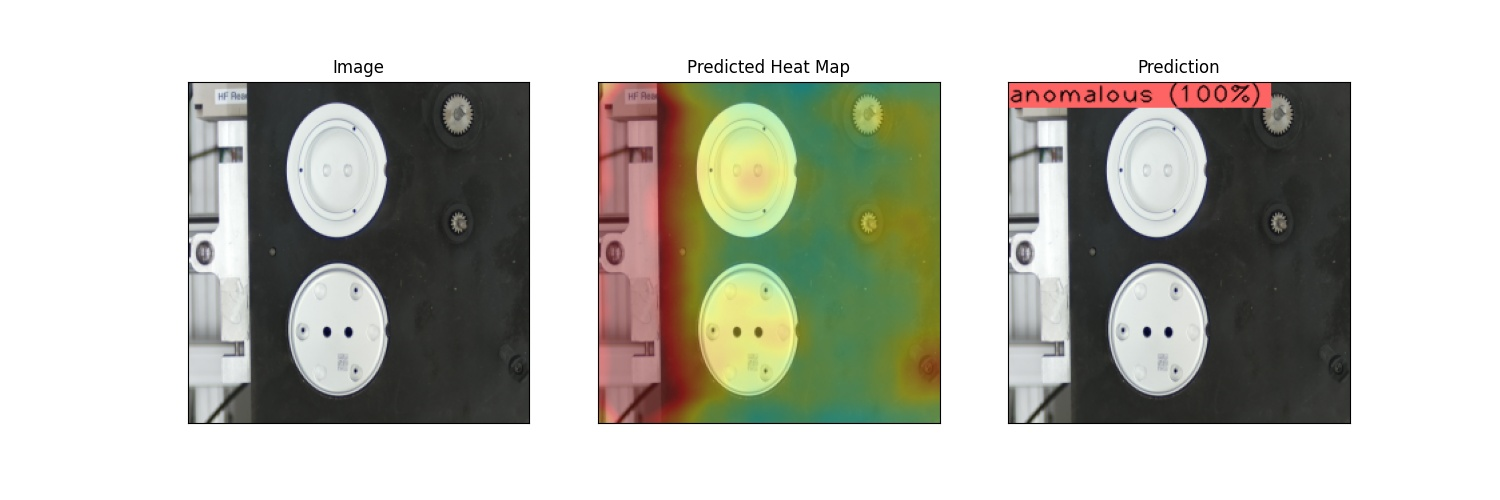

results/patchcore/20/run/images/Abnormal/Photo_1694699510.9207706.jpg


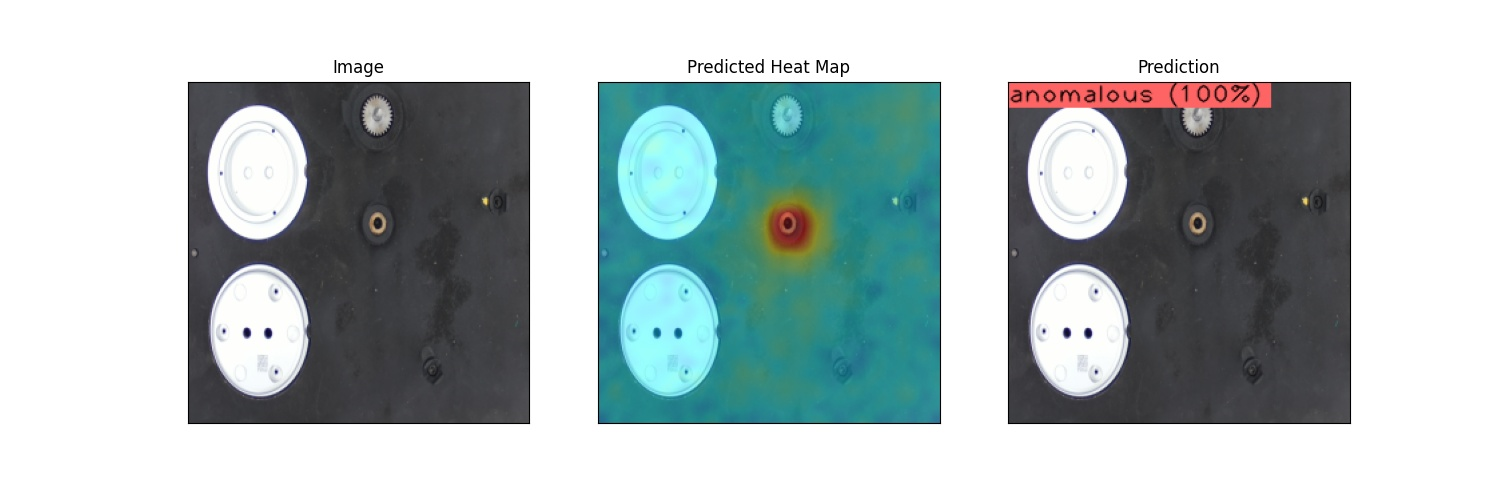

results/patchcore/20/run/images/Abnormal/Photo_1692963423.2933097.jpg


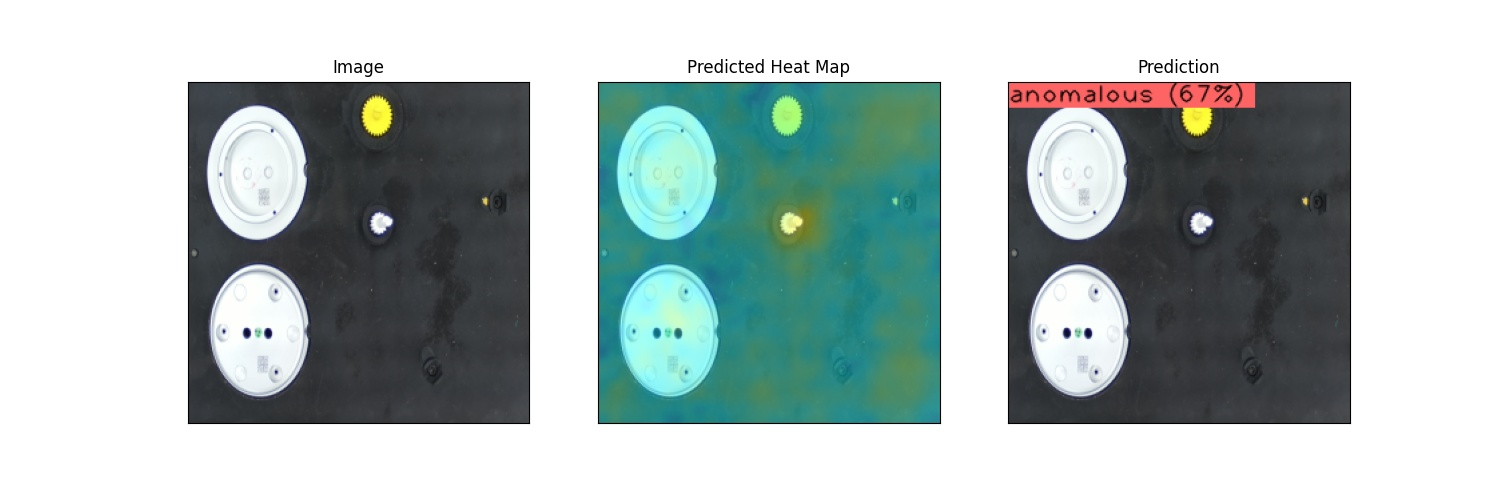

results/patchcore/20/run/images/Abnormal/Photo_1692963330.155605.jpg


results/patchcore/20/run/images/Abnormal/Photo_1692963270.0054336.jpg


results/patchcore/20/run/images/Abnormal/Photo_1694699513.9825485.jpg


results/patchcore/20/run/images/Abnormal/Photo_1694699751.3496962.jpg


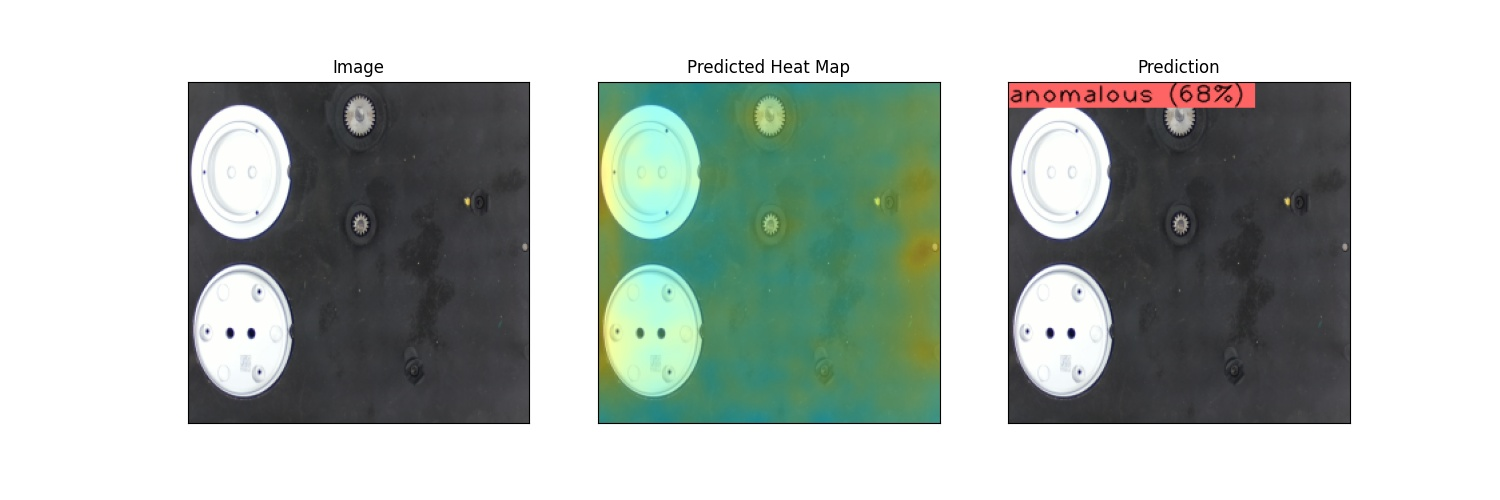

results/patchcore/20/run/images/Abnormal/Photo_1694699518.8427975.jpg


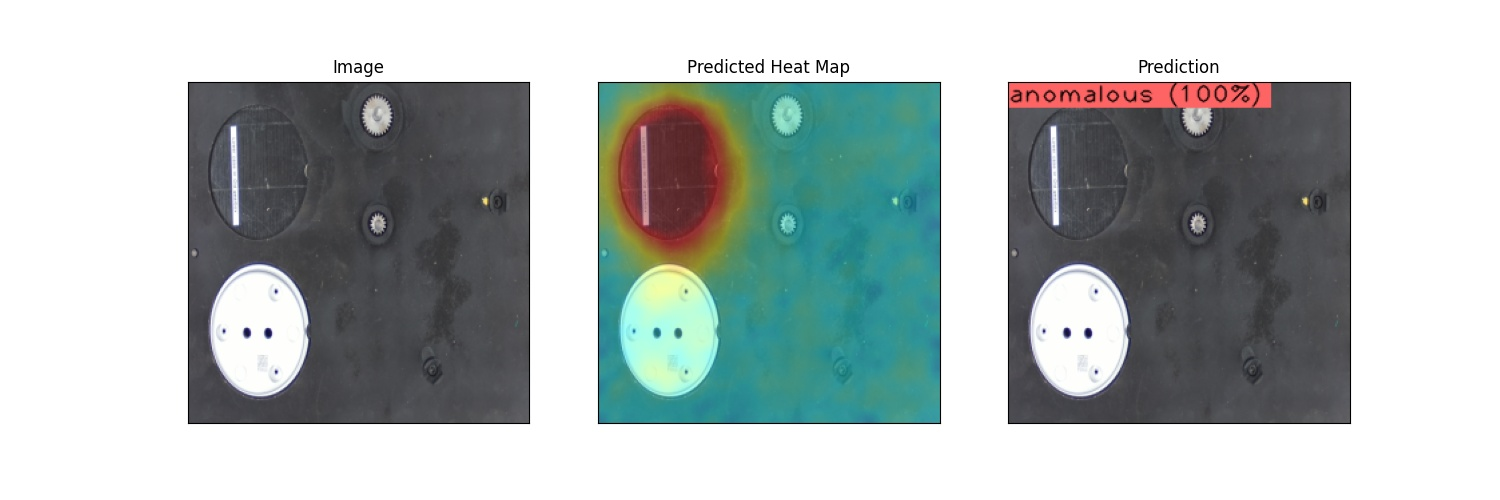

results/patchcore/20/run/images/Abnormal/Photo_1692963411.6456754.jpg


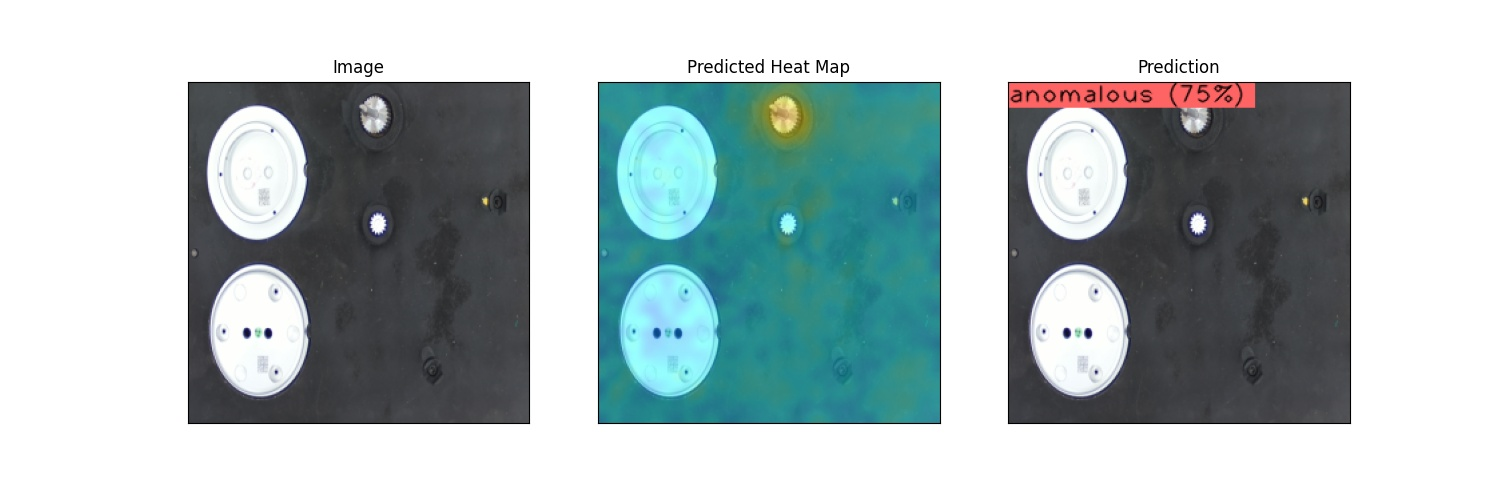

results/patchcore/20/run/images/Abnormal/Photo_1692963336.470491.jpg


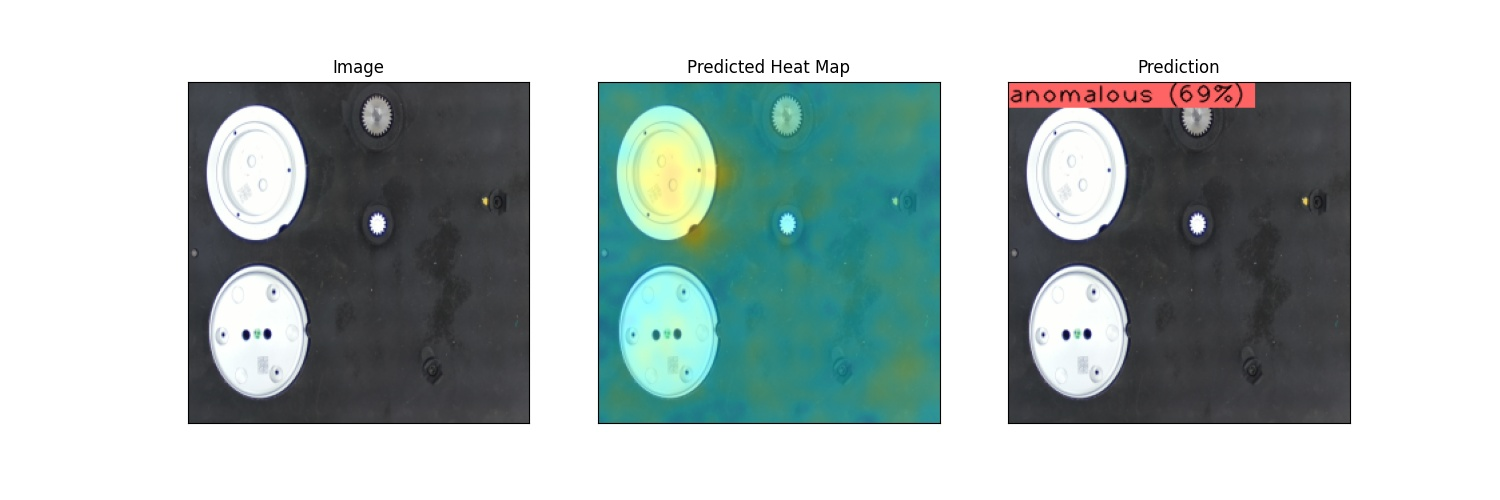

results/patchcore/20/run/images/Abnormal/Photo_1692963397.224298.jpg


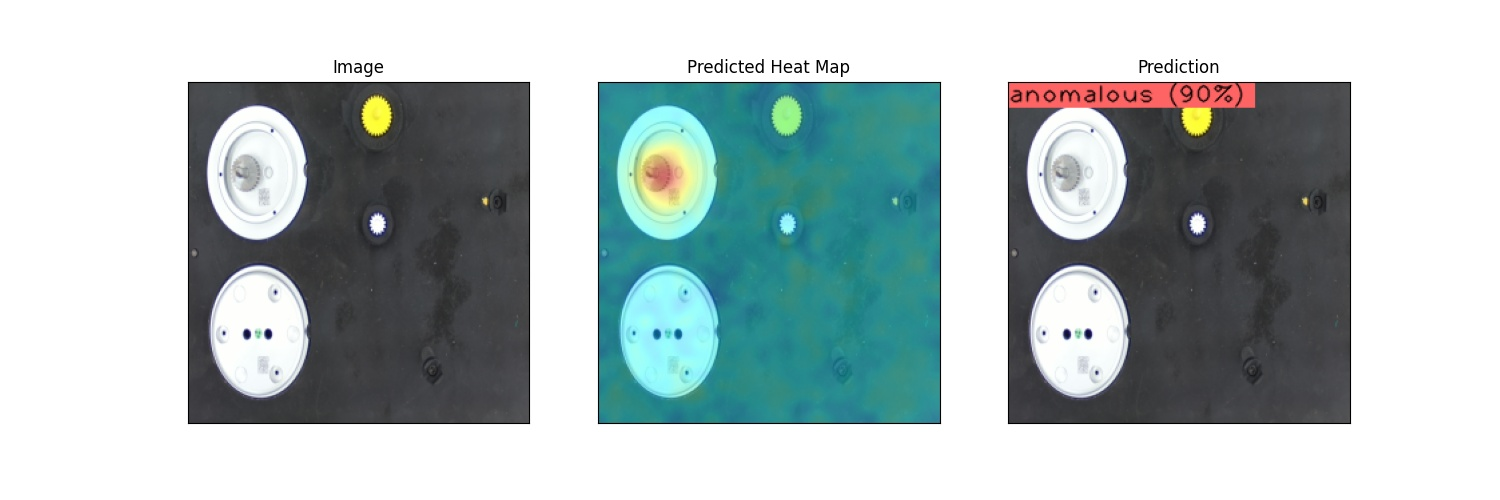

results/patchcore/20/run/images/Normal/Photo_1694699129.0658662.jpg


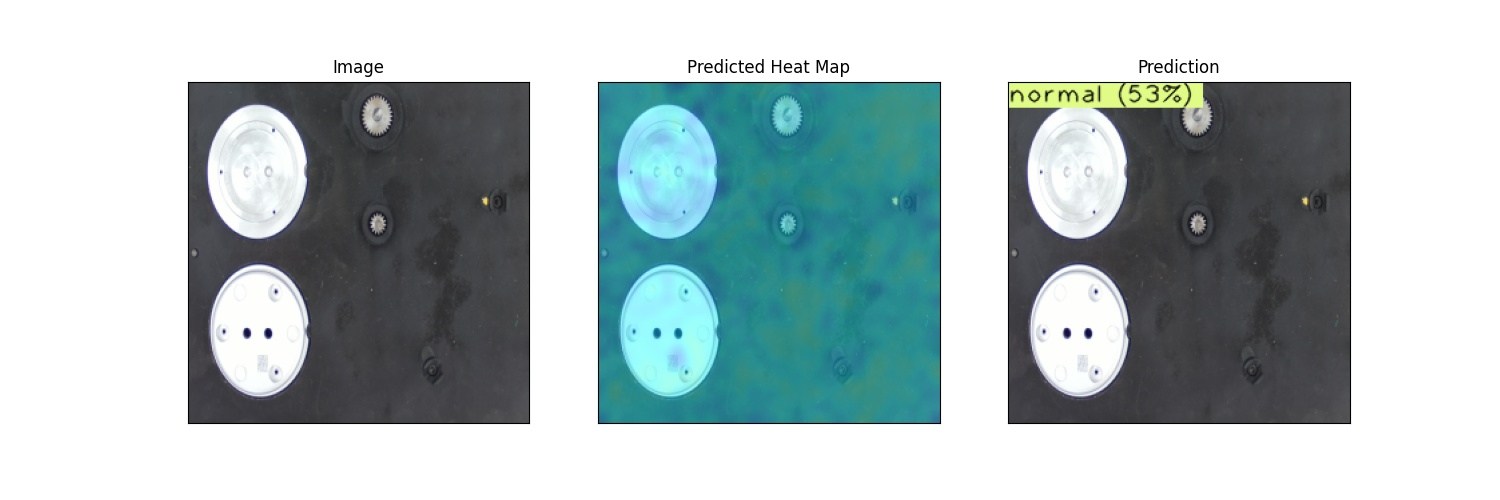

results/patchcore/20/run/images/Normal/Photo_1692963131.348655.jpg


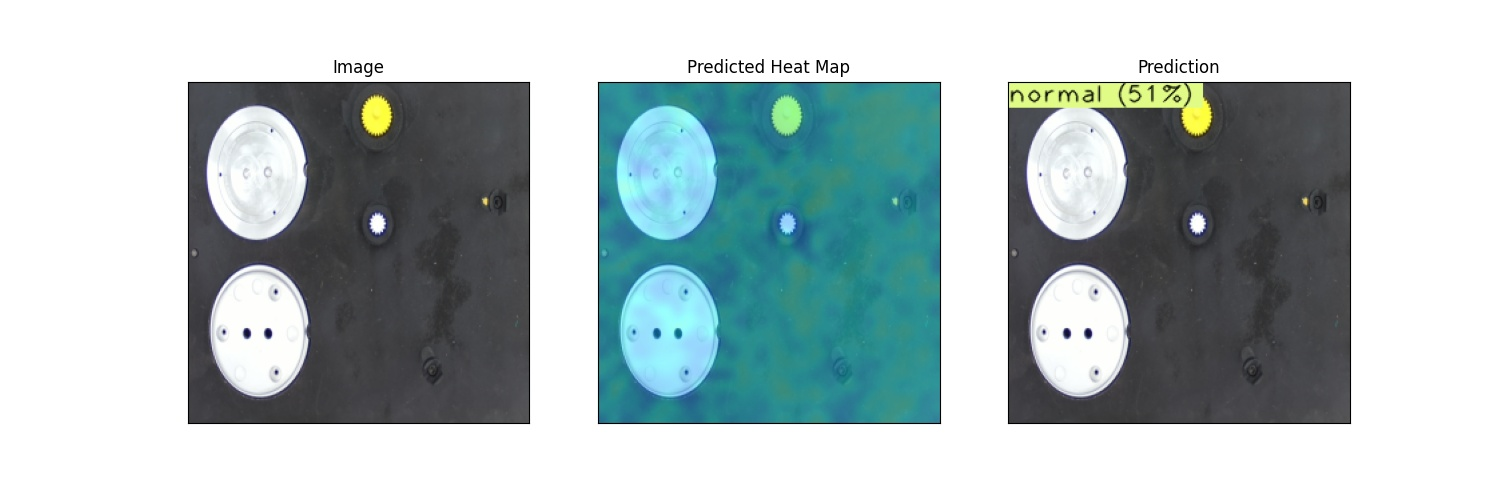

results/patchcore/20/run/images/Normal/Photo_1694699242.7396145.jpg


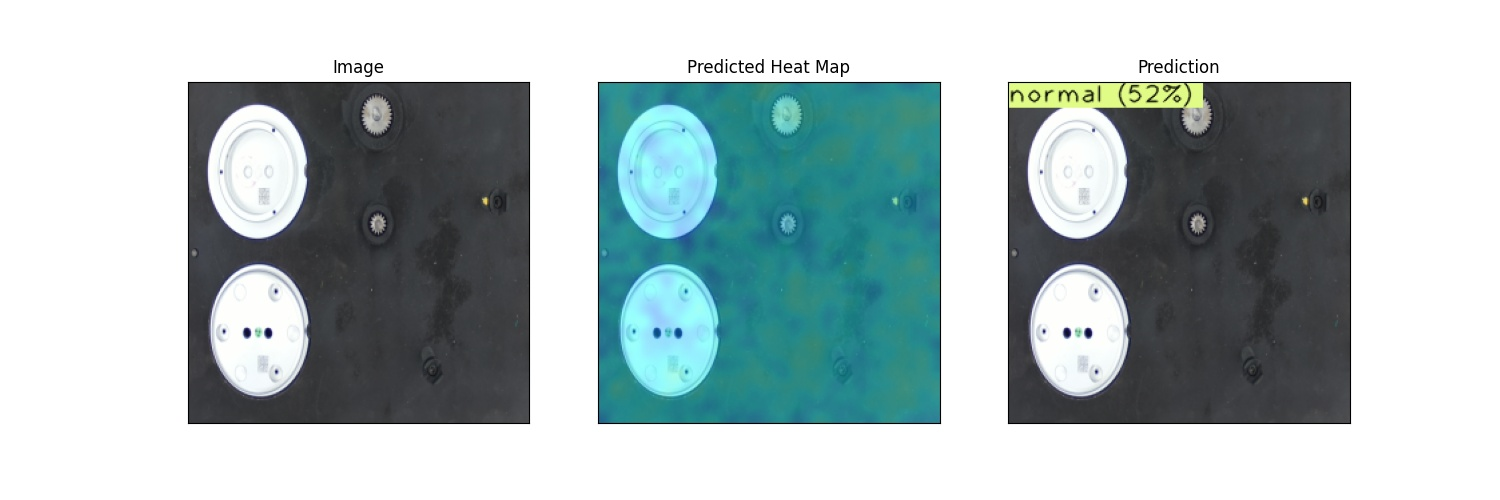

results/patchcore/20/run/images/Normal/Photo_1692963183.452791.jpg


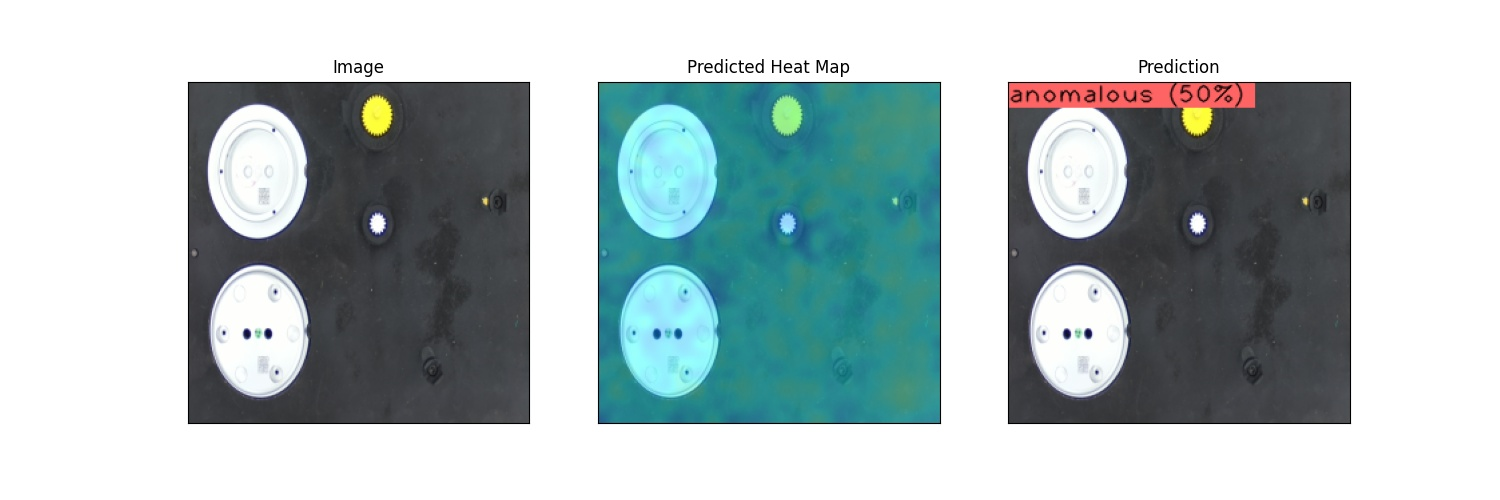

In [13]:

for filename in image_filenames1:
    print(filename)
    image = Image.open(filename)
    display(image)